<a href="https://colab.research.google.com/github/TrevinWacker/kickstarter_project_goal_setting/blob/main/Measuring_Varying_Project_Goals_to_Assess_Potential_Greater_Return_of_Amount_Pledged.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Measuring Varying Project Goals to Assess Potential Greater Return of Amount Pledged**

In this workbook, I’ll be examining a dataset containing multiple years of Kickstarter project data to assess the degree of success based on the initial asking goal amount, relative to excess money pledged.  The data comes from Kaggle by user Mickaël Moullié, chosen for its large count, having relatively recent data, and converting all monetary values into U.S. dollars to make for easier translation for globally funded projects involving multiple currencies.  I’m only going to assess projects between 1-30 days, as that’s what Kickstarter recommends to have see the greatest chance at project success.
My key metric is the pledged amount divided by set goal.  
      `key_metric = pledged / goal`

This is so that these two values have a relationship that can be measured more equally between different goal tiers, vs just having the pledge amount.  With this metric, extreme values would indicate either very successful or very ambitious projects, relative to goal amount, and could be determined to be outliers to discard.  To compare as equal projects as possible, I will be testing within each of the 15 main categories.  


```
'Games', 'Fashion', 'Film & Video', 'Technology', 'Art', 'Music',
       'Journalism', 'Design', 'Publishing', 'Comics', 'Crafts', 'Food',
       'Dance', 'Theater', 'Photography']
```

From there I will set a low and high tier of goals as my two test groups.  My null hypothesis is that the amount pledged over goal within the same category between lower and higher initial goals are equal; my alternative hypothesis is that they differ.  



The significance of this test would be showing that, if we can reject the null, there is a significant difference in amount pledged based on how you define your project by goal.  For example, if the key metric is positive when comparing a lower and higher initial goal tier group, then, on average, setting a higher goal amount ends up leading to relatively more funds.  This could indicate that backers who want to support a project aren’t deterred from donating solely based off the higher amount needed to raise, vs supporting a project that can be successful with less funds.  Knowing this, a project creator could set their goal higher than needed, because they will end up earning even more money over their goal.  Alternatively, if there’s no significant difference, then we can’t prove that, on average, any project earns relatively more than another based off of initial goal, and creators should just ask for the minimum amount they need.


All these points aim to inform those creating Kickstarter projects how their user set goals could end up affecting the total amount of money they will get.  While there are additional details influenced or decided by the creator, such as the popularity of the project creator, length of project, and the rewards offered for contributing, these tests aim to give a general insight into project success for one facet all projects have in common.



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import timedelta
import math

In [ ]:
# Must create new Kaggle API token to download kaggle.json
# Found how to download kaggle datasets from this url: https://www.kaggle.com/general/74235

import pandas as pd
! pip install -q kaggle
from google.colab import files

files.upload()  # upload kaggle.json





Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"trevinwacker","key":"b09f33130e7c41aedbcc91aac0db21c6"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets list

ref                                                          title                                           size  lastUpdated          downloadCount  
-----------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  
szymonjanowski/internet-articles-data-with-users-engagement  Internet news data with readers engagement       3MB  2020-11-21 17:09:57           3195  
sakshigoyal7/credit-card-customers                           Credit Card customers                          379KB  2020-11-19 07:38:44          11050  
imoore/2020-us-general-election-turnout-rates                2020 US General Election Turnout rates           4KB  2020-11-26 00:21:15           3401  
arashnic/hr-analytics-job-change-of-data-scientists          HR Analytics: Job Change of Data Scientists    295KB  2020-12-07 00:25:10             95  
afrniomelo/3w-dataset                                        3W Dataset - Undesirable ev

In [ ]:
! kaggle datasets download -d kemical/kickstarter-projects

! unzip kickstarter-projects.zip -d Downloads

with open('Downloads/ks-projects-201801.csv', encoding="utf8", errors='ignore') as f: ## This code/trick was found here on StackOverflow: https://stackoverflow.com/questions/42339876/error-unicodedecodeerror-utf-8-codec-cant-decode-byte-0xff-in-position-0-in
  ks_df_original = pd.read_csv(f)

 52% 19.0M/36.8M [00:00<00:00, 81.8MB/s]
100% 36.8M/36.8M [00:00<00:00, 123MB/s] 
Archive:  kickstarter-projects.zip
  inflating: Downloads/ks-projects-201612.csv  
  inflating: Downloads/ks-projects-201801.csv  


In [ ]:
ks_df_original.dtypes

ID                    int64
name                 object
category             object
main_category        object
currency             object
deadline             object
goal                float64
launched             object
pledged             float64
state                object
backers               int64
country              object
usd pledged         float64
usd_pledged_real    float64
usd_goal_real       float64
dtype: object

In [ ]:
# Examining raw data
ks_df_original.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [ ]:
# There are some null values in the usd_pledged_real field that will need to be addressed.
ks_df_original.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                378661 non-null  int64  
 1   name              378657 non-null  object 
 2   category          378661 non-null  object 
 3   main_category     378661 non-null  object 
 4   currency          378661 non-null  object 
 5   deadline          378661 non-null  object 
 6   goal              378661 non-null  float64
 7   launched          378661 non-null  object 
 8   pledged           378661 non-null  float64
 9   state             378661 non-null  object 
 10  backers           378661 non-null  int64  
 11  country           378661 non-null  object 
 12  usd pledged       374864 non-null  float64
 13  usd_pledged_real  378661 non-null  float64
 14  usd_goal_real     378661 non-null  float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


In [ ]:
ks_df = ks_df_original

## Getting rid of all the rows where we don't have proper info
ks_df.dropna(inplace=True)                   
ks_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374860 entries, 0 to 378660
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                374860 non-null  int64  
 1   name              374860 non-null  object 
 2   category          374860 non-null  object 
 3   main_category     374860 non-null  object 
 4   currency          374860 non-null  object 
 5   deadline          374860 non-null  object 
 6   goal              374860 non-null  float64
 7   launched          374860 non-null  object 
 8   pledged           374860 non-null  float64
 9   state             374860 non-null  object 
 10  backers           374860 non-null  int64  
 11  country           374860 non-null  object 
 12  usd pledged       374860 non-null  float64
 13  usd_pledged_real  374860 non-null  float64
 14  usd_goal_real     374860 non-null  float64
dtypes: float64(5), int64(2), object(8)
memory usage: 45.8+ MB


In [ ]:
# The 'pledged' field is in native currency, so to avoid confusion I'm deleting it
ks_df.drop('pledged', axis=1, inplace=True)
ks_df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,canceled,14,US,1283.0,1283.0,19500.00


In [ ]:
# The 'goal' and 'usd pledged' fields represent both the goal set and contribution made to a project in USD, but not the total amount pledged converted into USD,
# so I'm dropping them to avoid confusion
ks_df.drop('usd pledged', axis=1, inplace=True)
ks_df.drop('goal', axis=1, inplace=True)
ks_df.head()

,ID,name,category,main_category,currency,deadline,launched,state,backers,country,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,2015-08-11 12:12:28,failed,0,GB,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,2017-09-02 04:43:57,failed,15,US,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,2013-01-12 00:20:50,failed,3,US,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,2012-03-17 03:24:11,failed,1,US,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,2015-07-04 08:35:03,canceled,14,US,1283.0,19500.00


In [ ]:
# For accessibility, I'm redefining usd_pledged_real and usd_goal_real into pledged and goal, respectively, to be more concise
ks_df.rename(columns={'usd_pledged_real':'pledged', 'usd_goal_real':'goal'}, inplace=True)

In [ ]:
# Let's see what different states there are in the dataframe
ks_df['state'].unique()


array(['failed', 'canceled', 'successful', 'live', 'suspended'],
      dtype=object)

In [ ]:
# We only want to look completed projects, either having failed or succeeded, so we want to get rid of all projects where state = 'live', 'suspended', or 'canceled'
ks_df = ks_df[ks_df['state'] != 'canceled']
ks_df = ks_df[ks_df['state'] != 'live']
ks_df = ks_df[ks_df['state'] != 'suspended']
ks_df['state'].unique()

array(['failed', 'successful'], dtype=object)

In [ ]:
# Let's make sure the state field is accurate.
successful = ks_df[ks_df['pledged'] >= ks_df['goal']]  # Df with actual successful projects
successful['state'].unique()

array(['successful', 'failed'], dtype=object)

In [ ]:
# Because there are still projects labeled as 'failed' in the state field, we know it's not fully accurate, so we not use it as a reference.
ks_df.head()

,ID,name,category,main_category,currency,deadline,launched,state,backers,country,pledged,goal
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,2015-08-11 12:12:28,failed,0,GB,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,2017-09-02 04:43:57,failed,15,US,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,2013-01-12 00:20:50,failed,3,US,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,2012-03-17 03:24:11,failed,1,US,1.0,5000.00
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,2016-02-26 13:38:27,successful,224,US,52375.0,50000.00


In [ ]:
## Kickstarter's FAQ recommends having projects be within 30days, as success declines after that
## Let's cut down all the projects to 0-30 days
ks_df['deadline'] = pd.DatetimeIndex(data=ks_df['deadline'], freq='infer', ambiguous='infer').date          ## Converts the deadline & launched fields into
ks_df['launched'] = pd.DatetimeIndex(data=ks_df['launched'], freq='infer', ambiguous='infer').date          ## only dates
ks_df['day_length'] = ks_df['deadline'] - ks_df['launched']
ks_df.head(10)

,ID,name,category,main_category,currency,deadline,launched,state,backers,country,pledged,goal,day_length
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,2015-08-11,failed,0,GB,0.0,1533.95,59 days
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,2017-09-02,failed,15,US,2421.0,30000.00,60 days
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,2013-01-12,failed,3,US,220.0,45000.00,45 days
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,2012-03-17,failed,1,US,1.0,5000.00,30 days
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,2016-02-26,successful,224,US,52375.0,50000.00,35 days
6,1000023410,Support Solar Roasted Coffee & Green Energy! ...,Food,Food,USD,2014-12-21,2014-12-01,successful,16,US,1205.0,1000.00,20 days
7,1000030581,Chaser Strips. Our Strips make Shots their B*tch!,Drinks,Food,USD,2016-03-17,2016-02-01,failed,40,US,453.0,25000.00,45 days
10,100004721,Of Jesus and Madmen,Nonfiction,Publishing,CAD,2013-10-09,2013-09-09,failed,0,CA,0.0,2406.39,30 days
11,100005484,Lisa Lim New CD!,Indie Rock,Music,USD,2013-04-08,2013-03-09,successful,100,US,12700.0,12500.00,30 days
12,1000055792,The Cottage Market,Crafts,Crafts,USD,2014-10-02,2014-09-02,failed,0,US,0.0,5000.00,30 days


In [ ]:
### Turning day_length into an integer
ks_df['test'] = pd.to_numeric(ks_df['day_length'], errors='coerce') ## Was unable to find python language to turn timedelta object into interger so using this workaround
ks_df = ks_df[ks_df['test'] <= 2592000000000000]  # This long value is equal to 30days in day_length
ks_df.head(10)

,ID,name,category,main_category,currency,deadline,launched,state,backers,country,pledged,goal,day_length,test
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,2012-03-17,failed,1,US,1.00,5000.00,30 days,2592000000000000
6,1000023410,Support Solar Roasted Coffee & Green Energy! ...,Food,Food,USD,2014-12-21,2014-12-01,successful,16,US,1205.00,1000.00,20 days,1728000000000000
10,100004721,Of Jesus and Madmen,Nonfiction,Publishing,CAD,2013-10-09,2013-09-09,failed,0,CA,0.00,2406.39,30 days,2592000000000000
11,100005484,Lisa Lim New CD!,Indie Rock,Music,USD,2013-04-08,2013-03-09,successful,100,US,12700.00,12500.00,30 days,2592000000000000
12,1000055792,The Cottage Market,Crafts,Crafts,USD,2014-10-02,2014-09-02,failed,0,US,0.00,5000.00,30 days,2592000000000000
14,1000057089,Tombstone: Old West tabletop game and miniatur...,Tabletop Games,Games,GBP,2017-05-03,2017-04-05,successful,761,GB,121857.33,6469.73,28 days,2419200000000000
15,1000064368,Survival Rings,Design,Design,USD,2015-02-28,2015-01-29,failed,11,US,664.00,2500.00,30 days,2592000000000000
16,1000064918,The Beard,Comic Books,Comics,USD,2014-11-08,2014-10-09,failed,16,US,395.00,1500.00,30 days,2592000000000000
17,1000068480,Notes From London: Above & Below,Art Books,Publishing,USD,2015-05-10,2015-04-10,failed,20,US,789.00,3000.00,30 days,2592000000000000
18,1000070642,Mike Corey's Darkness & Light Album,Music,Music,USD,2012-08-17,2012-08-02,successful,7,US,250.00,250.00,15 days,1296000000000000


In [ ]:
# Dropping test field to keep eliminate unneeded and confusing field of dataframe
ks_df.drop('test', axis=1, inplace=True) 
ks_df.info()
ks_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 211281 entries, 3 to 378660
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype          
---  ------         --------------   -----          
 0   ID             211281 non-null  int64          
 1   name           211281 non-null  object         
 2   category       211281 non-null  object         
 3   main_category  211281 non-null  object         
 4   currency       211281 non-null  object         
 5   deadline       211281 non-null  object         
 6   launched       211281 non-null  object         
 7   state          211281 non-null  object         
 8   backers        211281 non-null  int64          
 9   country        211281 non-null  object         
 10  pledged        211281 non-null  float64        
 11  goal           211281 non-null  float64        
 12  day_length     211281 non-null  timedelta64[ns]
dtypes: float64(2), int64(2), object(8), timedelta64[ns](1)
memory usage: 22.6+ MB


,ID,name,category,main_category,currency,deadline,launched,state,backers,country,pledged,goal,day_length
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,2012-03-17,failed,1,US,1.0,5000.00,30 days
6,1000023410,Support Solar Roasted Coffee & Green Energy! ...,Food,Food,USD,2014-12-21,2014-12-01,successful,16,US,1205.0,1000.00,20 days
10,100004721,Of Jesus and Madmen,Nonfiction,Publishing,CAD,2013-10-09,2013-09-09,failed,0,CA,0.0,2406.39,30 days
11,100005484,Lisa Lim New CD!,Indie Rock,Music,USD,2013-04-08,2013-03-09,successful,100,US,12700.0,12500.00,30 days
12,1000055792,The Cottage Market,Crafts,Crafts,USD,2014-10-02,2014-09-02,failed,0,US,0.0,5000.00,30 days


(array([    0.,     0.,     0.,     0.,     0.,     0.,     0., 30917.,
       27593.]), array([2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]), <a list of 9 Patch objects>)


,ID,name,category,main_category,currency,deadline,launched,state,backers,country,pledged,goal,day_length,key_metric
year,,,,,,,,,,,,,,
2016,30917,30917,30917,30917,30917,30917,30917,30917,30917,30917,30917,30917,30917,30917
2017,27593,27593,27593,27593,27593,27593,27593,27593,27593,27593,27593,27593,27593,27593


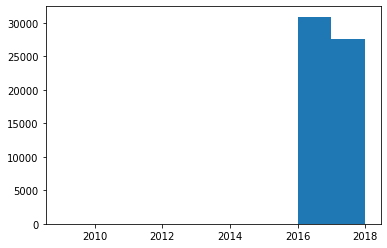

In [ ]:
#Now time to determine if we should keep all years                                                 
ks_df['year'] = pd.DatetimeIndex(data=ks_df['launched'], freq='infer', ambiguous='infer').year
print(plt.hist(ks_df['year'], range(2009, 2019))) #Kickstarter was founded in 2009 and the data is only through the year 2017
ks_df.groupby('year').count()

In [ ]:
# It stands to reason the most recent data would be the most applicable to guage current user behavior, so I'm only going to use projects from 2016 on.
# There are lots of datapoints that are contained there, likely enough to test on once we divide this data into further categories.
ks_df = ks_df[ks_df['year'] >= 2016]
ks_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62313 entries, 14 to 378654
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype          
---  ------         --------------  -----          
 0   ID             62313 non-null  int64          
 1   name           62313 non-null  object         
 2   category       62313 non-null  object         
 3   main_category  62313 non-null  object         
 4   currency       62313 non-null  object         
 5   deadline       62313 non-null  object         
 6   launched       62313 non-null  object         
 7   state          62313 non-null  object         
 8   backers        62313 non-null  int64          
 9   country        62313 non-null  object         
 10  pledged        62313 non-null  float64        
 11  goal           62313 non-null  float64        
 12  day_length     62313 non-null  timedelta64[ns]
 13  year           62313 non-null  int64          
dtypes: float64(2), int64(3), object(8), timedelta64[ns](

In [ ]:
# Finally we want goal to be greater than or equal to 0, and pledged to be greater than or equal to 1
ks_df = ks_df[ks_df['goal'] >= 1]
ks_df = ks_df[ks_df['pledged'] >= 0]
ks_df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62308 entries, 14 to 378654
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype          
---  ------         --------------  -----          
 0   ID             62308 non-null  int64          
 1   name           62308 non-null  object         
 2   category       62308 non-null  object         
 3   main_category  62308 non-null  object         
 4   currency       62308 non-null  object         
 5   deadline       62308 non-null  object         
 6   launched       62308 non-null  object         
 7   state          62308 non-null  object         
 8   backers        62308 non-null  int64          
 9   country        62308 non-null  object         
 10  pledged        62308 non-null  float64        
 11  goal           62308 non-null  float64        
 12  day_length     62308 non-null  timedelta64[ns]
 13  year           62308 non-null  int64          
dtypes: float64(2), int64(3), object(8), timedelta64[ns](

(array([6.2299e+04, 3.0000e+00, 4.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([    0. ,  3284.3,  6568.6,  9852.9, 13137.2, 16421.5, 19705.8,
        22990.1, 26274.4, 29558.7, 32843. ]),
 <a list of 10 Patch objects>)

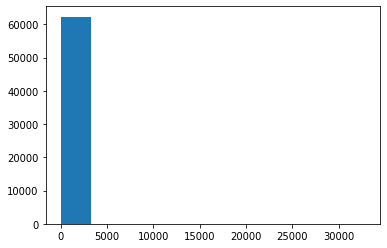

In [ ]:
# Now let's define our key metric
ks_df['key_metric'] = (ks_df['pledged'] / ks_df['goal']) # Measuring how much more/less pledged amount is compared to goal
ks_df['key_metric'].describe()
plt.hist(ks_df['key_metric'])

# For key metric values:
## key_metric < 1    The pledged didn't meet the goal and the project failed
## key_metric = 1    The pledged met the goal exactly and the project was successful
## key_metric > 1    The pledged beat the goal and the project exceeded expectations

In [ ]:
## Because a majority of the data is before 1.5, and the data centers on 3.5, I'm going to limit the key_metric to those projects that aren't 
## runaway successful
ks_df = ks_df[ks_df['key_metric'] <= 3.5]
ks_df.info() 

# This takes away about 4000 projects total, leaving plenty to still test on 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58510 entries, 21 to 378654
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype          
---  ------         --------------  -----          
 0   ID             58510 non-null  int64          
 1   name           58510 non-null  object         
 2   category       58510 non-null  object         
 3   main_category  58510 non-null  object         
 4   currency       58510 non-null  object         
 5   deadline       58510 non-null  object         
 6   launched       58510 non-null  object         
 7   state          58510 non-null  object         
 8   backers        58510 non-null  int64          
 9   country        58510 non-null  object         
 10  pledged        58510 non-null  float64        
 11  goal           58510 non-null  float64        
 12  day_length     58510 non-null  timedelta64[ns]
 13  year           58510 non-null  int64          
 14  key_metric     58510 non-null  float64        
dtype

DescribeResult(nobs=58510, minmax=(0.0, 3.499), mean=0.5813924767547014, variance=0.540033657222457, skewness=1.3169082562360979, kurtosis=1.4033924114508398)

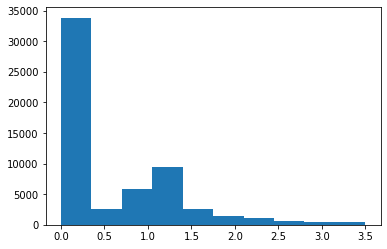

In [ ]:
plt.hist(ks_df['key_metric'])
stats.describe(ks_df['key_metric'])
# Its stats allow for testing on Normality, but because it's still very skewed (and because I don't want to take away values near 1)
# I'll do dependent Kruskal testing

In [ ]:
#Let's see some overall stats on the key_metric
successful = ks_df[ks_df['key_metric'] >= 1].copy()
failed = ks_df[ks_df['key_metric'] < 1].copy()

print('Key metric stats for successful projects:')
print(successful['key_metric'].describe())
print()
print('Key metric stats for failed projects')
print(failed['key_metric'].describe())

Key metric stats for successful projects:
count    21656.000000
mean         1.417612
std          0.553479
min          1.000000
25%          1.049680
50%          1.170417
75%          1.552700
max          3.499000
Name: key_metric, dtype: float64

Key metric stats for failed projects
count    36854.000000
mean         0.090017
std          0.158121
min          0.000000
25%          0.000200
50%          0.012500
75%          0.104667
max          0.991000
Name: key_metric, dtype: float64


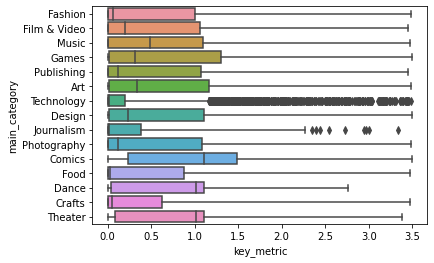

In [ ]:
# Here are the distributions of all categories, relative to each other
sns.boxplot(data=ks_df, x='key_metric', y='main_category', whis=5);

This looks as expected, with many projects being put up that aren't successful at all, not so many values for partially successful projects, and a jump around
1, representing close to or perfectly successful projects


KruskalResult(statistic=182.54323952088004, pvalue=1.349425683278501e-41)

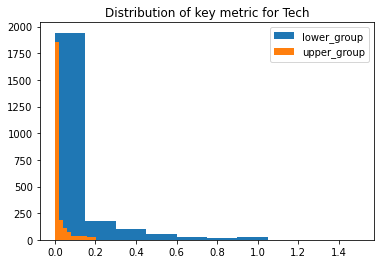

In [ ]:
# Let's look at the distribution of a sample category: Tech

df = ks_df[ks_df['main_category'] == 'Technology']
median = df['goal'].median()
lower_group = df[df['goal'] < median]
iqr = 1.5 * (lower_group['key_metric'].quantile(0.75) - lower_group['key_metric'].quantile(0.25)) #Eliminating outliers

upper_group = df[df['goal'] > median]
iqr_2 = 1.5 * (upper_group['key_metric'].quantile(0.75) - upper_group['key_metric'].quantile(0.25)) #Eliminating outliers

lower_group = lower_group[lower_group['key_metric'] >= (lower_group['key_metric'].quantile(0.25) - iqr)]
lower_group = lower_group[lower_group['key_metric'] <= (lower_group['key_metric'].quantile(0.75) + iqr)]

upper_group = upper_group[upper_group['key_metric'] <= (upper_group['key_metric'].quantile(0.75) + iqr_2)]
upper_group = upper_group[upper_group['key_metric'] >= (upper_group['key_metric'].quantile(0.25) - iqr_2)]


plt.hist(lower_group['key_metric'], range=(0, 1.5))
plt.hist(upper_group['key_metric'])
plt.legend(['lower_group', 'upper_group'])
plt.title('Distribution of key metric for Tech');

stats.kruskal(upper_group['key_metric'], lower_group['key_metric'])
# It's very clearly different

In [ ]:
# There are fifteen main categories.  Tests will be conducted within dataframes of only a single category to test as equal projects as possible
ks_df['main_category'].unique()

array(['Fashion', 'Film & Video', 'Music', 'Games', 'Publishing', 'Art',
       'Technology', 'Design', 'Journalism', 'Photography', 'Comics',
       'Food', 'Dance', 'Crafts', 'Theater'], dtype=object)

Now we want to see if having a higher asking goal increases the percent amount over you get back. 

To measure this, I'm going divide datasets by lower goal and higher goal, and then running a Kruskel test on their respective key_metrics.  Kruskel seems to be the most appropriate test as distribution of the key metric doesn't follow a normal distribution for any category

In [ ]:
### Testing between lower goal and higher goal project
def sig_test(df):   ## For running a test on a dataframe
  median = df['goal'].median()
  lower_group = df[df['goal'] < median]
  iqr = 1.5 * (lower_group['key_metric'].quantile(0.75) - lower_group['key_metric'].quantile(0.25)) #Eliminating outliers
  lower_group = lower_group[lower_group['key_metric'] >= (lower_group['key_metric'].quantile(0.25) - iqr)]
  upper_group = df[df['goal'] > median]
  iqr_2 = 1.5 * (upper_group['key_metric'].quantile(0.75) - upper_group['key_metric'].quantile(0.25)) #Eliminating outliers
  upper_group = upper_group[upper_group['key_metric'] <= (upper_group['key_metric'].quantile(0.75) + iqr)]
  return stats.f_oneway(lower_group['key_metric'], upper_group['key_metric']), 'Skewness: {}  Kurtosis: {}'.format(stats.describe(upper_group['key_metric'])[4],stats.describe(upper_group['key_metric'])[5])

sig_test(ks_df) # Results of 2-tier Kruskal test on all the data

(F_onewayResult(statistic=3114.580533656878, pvalue=0.0),
 'Skewness: 1.346229390807285  Kurtosis: 0.9779231894740263')

In [ ]:
## Let's gather all results together

categories = ks_df['main_category'].unique()
two_tier_results = []
for i in categories:    ## Testing on all categories
    test_cat = ks_df[ks_df['main_category'] == i]
    j = sig_test(test_cat)
    two_tier_results.append((i, len(test_cat), j[0][1], j[1]))

# Lists all test results from 2-tier Kruskal test
two_tier_results 

[('Fashion',
  4719,
  1.7093943950685286e-32,
  'Skewness: 1.4437071904421945  Kurtosis: 0.6833304768683979'),
 ('Film & Video',
  7153,
  2.7487696273658525e-54,
  'Skewness: 0.7757352178625169  Kurtosis: -0.697555719508026'),
 ('Music',
  5951,
  1.3018863792117463e-15,
  'Skewness: 0.5308550352370661  Kurtosis: -0.7288183690830432'),
 ('Games',
  6478,
  4.399447520678594e-52,
  'Skewness: 1.3274910372402886  Kurtosis: 0.9844984983841623'),
 ('Publishing',
  6277,
  4.0073081851376586e-44,
  'Skewness: 1.2661964135716026  Kurtosis: 0.6747300670448717'),
 ('Art',
  4603,
  3.10602742619607e-91,
  'Skewness: 1.080927471007133  Kurtosis: 0.2376861713644658'),
 ('Technology',
  6043,
  1.9833406407861044e-132,
  'Skewness: 3.5597418407013017  Kurtosis: 13.793920363382917'),
 ('Design',
  5021,
  6.83255276620259e-56,
  'Skewness: 1.429549904582063  Kurtosis: 1.2693505639035685'),
 ('Journalism',
  811,
  1.0567235191238493e-09,
  'Skewness: 1.8478943920409086  Kurtosis: 1.7513137446762

In [ ]:
two_tier_df = pd.DataFrame(two_tier_results, columns=['Category', '# of datapoints', 'p-value', 'Normality stats'])
two_tier_df

,Category,# of datapoints,p-value,Normality stats
0,Fashion,4719,1.709394e-32,Skewness: 1.4437071904421945 Kurtosis: 0.6833...
1,Film & Video,7153,2.748770e-54,Skewness: 0.7757352178625169 Kurtosis: -0.697...
2,Music,5951,1.301886e-15,Skewness: 0.5308550352370661 Kurtosis: -0.728...
3,Games,6478,4.399448e-52,Skewness: 1.3274910372402886 Kurtosis: 0.9844...
4,Publishing,6277,4.007308e-44,Skewness: 1.2661964135716026 Kurtosis: 0.6747...
5,Art,4603,3.106027e-91,Skewness: 1.080927471007133 Kurtosis: 0.23768...
6,Technology,6043,1.983341e-132,Skewness: 3.5597418407013017 Kurtosis: 13.793...
7,Design,5021,6.832553e-56,Skewness: 1.429549904582063 Kurtosis: 1.26935...
8,Journalism,811,1.056724e-09,Skewness: 1.8478943920409086 Kurtosis: 1.7513...
9,Photography,1394,1.910695e-10,Skewness: 1.1250945266465961 Kurtosis: 0.3802...


In [ ]:
## Crafts and Technology indicate non-normality so a Kruskal test will be performed instead
df = ks_df[ks_df['main_category'] == 'Crafts']

median = df['goal'].median()
lower_group = df[df['goal'] < median]
iqr = 1.5 * (lower_group['key_metric'].quantile(0.75) - lower_group['key_metric'].quantile(0.25)) #Eliminating outliers
lower_group = lower_group[lower_group['key_metric'] >= (lower_group['key_metric'].quantile(0.25) - iqr)]
upper_group = df[df['goal'] > median]
iqr_2 = 1.5 * (upper_group['key_metric'].quantile(0.75) - upper_group['key_metric'].quantile(0.25)) #Eliminating outliers
upper_group = upper_group[upper_group['key_metric'] <= (upper_group['key_metric'].quantile(0.75) + iqr)]
print('Sigificance p-value for all craft projects: {}'.format(stats.kruskal(lower_group['key_metric'], upper_group['key_metric'])[1]))


df = ks_df[ks_df['main_category'] == 'Technology']

median = df['goal'].median()
lower_group = df[df['goal'] < median]
iqr = 1.5 * (lower_group['key_metric'].quantile(0.75) - lower_group['key_metric'].quantile(0.25)) #Eliminating outliers
lower_group = lower_group[lower_group['key_metric'] >= (lower_group['key_metric'].quantile(0.25) - iqr)]
upper_group = df[df['goal'] > median]
iqr_2 = 1.5 * (upper_group['key_metric'].quantile(0.75) - upper_group['key_metric'].quantile(0.25)) #Eliminating outliers
upper_group = upper_group[upper_group['key_metric'] <= (upper_group['key_metric'].quantile(0.75) + iqr)]
print('Sigificance p-value for all technology projects: {}'.format(stats.kruskal(lower_group['key_metric'], upper_group['key_metric'])[1]))

Sigificance p-value for all craft projects: 1.249353008724633e-65
Sigificance p-value for all technology projects: 1.8095259014050436e-96


All categories indicated that there is a sig. difference in the key_metric for lower goal and higher goal projects, indicating we can reject the null hypothesis at the 95% significance level, meaning that there is a difference in success on average between less and more expensive projects within the same category, and there is a disadvantage in increasing goal more than necessary.

In [ ]:
## Let's see if there's more nuance within the data

quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
categories = ks_df['main_category'].unique()
tests_2 = []

for category in categories:
  df = ks_df[ks_df['main_category'] == category]
  
  for i in quantiles:
    lower_group = df[df['goal'] > df['goal'].quantile(i - 0.1)]      
    lower_group = df[df['goal'] < df['goal'].quantile(i)]
    iqr_lower = 1.5 * (lower_group['key_metric'].quantile(0.75) - lower_group['key_metric'].quantile(0.25)) #Eliminating outliers
    lower_group = lower_group[lower_group['key_metric'] >= (lower_group['key_metric'].quantile(0.25) - iqr_lower)]
    lower_group = lower_group[lower_group['key_metric'] <= (lower_group['key_metric'].quantile(0.75) + iqr_lower)]


    upper_group = df[df['goal'] > df['goal'].quantile(i)]
    upper_group = df[df['goal'] < df['goal'].quantile(i + 0.1)]
    iqr_upper = 1.5 * (upper_group['key_metric'].quantile(0.75) - upper_group['key_metric'].quantile(0.25)) #Eliminating outliers
    upper_group = upper_group[upper_group['key_metric'] >= (upper_group['key_metric'].quantile(0.25) - iqr_upper)]
    upper_group = upper_group[upper_group['key_metric'] <= (upper_group['key_metric'].quantile(0.75) + iqr_upper)]

    whole_group = df[df['goal'] > df['goal'].quantile(i - 0.1)]
    whole_group = df[df['goal'] < df['goal'].quantile(i + 0.1)]

    j =  stats.f_oneway(lower_group['key_metric'], upper_group['key_metric'])
    tests_2.append([category, len(whole_group), j[1], str(i*10), whole_group['key_metric'].mean(), 'Skewness: {}  Kurtosis: {}'.format(stats.describe(upper_group['key_metric'])[4],stats.describe(upper_group['key_metric'])[5])])

tests_2

[['Fashion',
  859,
  0.002156923627227256,
  '1.0',
  0.7403132544445948,
  'Skewness: 0.9120050087466289  Kurtosis: -0.021597013122814257'],
 ['Fashion',
  1390,
  6.478903522338927e-05,
  '2.0',
  0.6279000075362858,
  'Skewness: 1.0790121517931166  Kurtosis: 0.15239608485267553'],
 ['Fashion',
  1888,
  0.0018741136245684115,
  '3.0',
  0.5593125835088923,
  'Skewness: 1.2173134677147446  Kurtosis: 0.41054173089359036'],
 ['Fashion',
  2213,
  0.2636985613753813,
  '4.0',
  0.536918412924685,
  'Skewness: 1.263007223963238  Kurtosis: 0.5113068920302917'],
 ['Fashion',
  2831,
  0.042682963044947564,
  '5.0',
  0.493144214408162,
  'Skewness: 1.3396122086848243  Kurtosis: 0.7140764997729487'],
 ['Fashion',
  3070,
  0.8610601171402757,
  '6.0',
  0.486557876807171,
  'Skewness: 1.3473767552956277  Kurtosis: 0.7415407816727773'],
 ['Fashion',
  3680,
  0.6283693455065231,
  '7.0',
  0.47437595340110567,
  'Skewness: 1.3438858487922127  Kurtosis: 0.735807886932792'],
 ['Fashion',
  42

In [ ]:
full_df = pd.DataFrame(tests_2, columns=['Category', '# of datapoints','P-value','Tier', 'Avg. Key Metric', 'Normality Stats'])
full_df


,Category,# of datapoints,P-value,Tier,Avg. Key Metric,Normality Stats
0,Fashion,859,0.002157,1.0,0.740313,Skewness: 0.9120050087466289 Kurtosis: -0.021...
1,Fashion,1390,0.000065,2.0,0.627900,Skewness: 1.0790121517931166 Kurtosis: 0.1523...
2,Fashion,1888,0.001874,3.0,0.559313,Skewness: 1.2173134677147446 Kurtosis: 0.4105...
3,Fashion,2213,0.263699,4.0,0.536918,Skewness: 1.263007223963238 Kurtosis: 0.51130...
4,Fashion,2831,0.042683,5.0,0.493144,Skewness: 1.3396122086848243 Kurtosis: 0.7140...
...,...,...,...,...,...,...
130,Theater,744,0.728904,5.0,0.900272,Skewness: -0.28511584808984086 Kurtosis: -0.5...
131,Theater,886,0.487080,6.0,0.876760,Skewness: -0.2829012910749907 Kurtosis: -0.55...
132,Theater,1001,0.462643,7.0,0.855733,Skewness: -0.23632876870438582 Kurtosis: -0.5...
133,Theater,1139,0.471649,8.0,0.830862,Skewness: -0.13754312284323478 Kurtosis: -0.5...


In [ ]:
## Check Normality stats to verify ANOVA test was cleared
category = input()
df = full_df[full_df['Category'] == category]
print(df['Normality Stats'])  

## Tiers 4-9 of Tech & the last tier of Journalism can't be assumed normal distributions, so Kruskal test will be used instead

Art
45    Skewness: 0.6466385077941692  Kurtosis: -0.302...
46    Skewness: 0.7154468172928401  Kurtosis: -0.173...
47    Skewness: 0.7229127023631969  Kurtosis: -0.197...
48    Skewness: 0.707808928158546  Kurtosis: -0.2419...
49    Skewness: 0.7507099274701396  Kurtosis: -0.178...
50    Skewness: 0.7484753924367876  Kurtosis: -0.197...
51    Skewness: 0.7688049573531108  Kurtosis: -0.218...
52    Skewness: 0.7862446445767566  Kurtosis: -0.227...
53    Skewness: 0.845374185162733  Kurtosis: -0.1855...
Name: Normality Stats, dtype: object


In [ ]:
## Needed Kruskal tests
kruskal_categories = ['Technology', 'Journalism']
tests_for_kruskal = []

for category in kruskal_categories:
  df = ks_df[ks_df['main_category'] == category]
  
  for i in quantiles:
    lower_group = df[df['goal'] > df['goal'].quantile(i - 0.1)]      
    lower_group = df[df['goal'] < df['goal'].quantile(i)]
    iqr_lower = 1.5 * (lower_group['key_metric'].quantile(0.75) - lower_group['key_metric'].quantile(0.25)) #Eliminating outliers
    lower_group = lower_group[lower_group['key_metric'] >= (lower_group['key_metric'].quantile(0.25) - iqr_lower)]
    lower_group = lower_group[lower_group['key_metric'] <= (lower_group['key_metric'].quantile(0.75) + iqr_lower)]


    upper_group = df[df['goal'] > df['goal'].quantile(i)]
    upper_group = df[df['goal'] < df['goal'].quantile(i + 0.1)]
    iqr_upper = 1.5 * (upper_group['key_metric'].quantile(0.75) - upper_group['key_metric'].quantile(0.25)) #Eliminating outliers
    upper_group = upper_group[upper_group['key_metric'] >= (upper_group['key_metric'].quantile(0.25) - iqr_upper)]
    upper_group = upper_group[upper_group['key_metric'] <= (upper_group['key_metric'].quantile(0.75) + iqr_upper)]

    whole_group = df[df['goal'] > df['goal'].quantile(i - 0.1)]
    whole_group = df[df['goal'] < df['goal'].quantile(i + 0.1)]

    j =  stats.kruskal(lower_group['key_metric'], upper_group['key_metric'])
    tests_for_kruskal.append([category, 'Tier {}'.format(i*10),j[1]])

tests_for_kruskal

## The ones that don't end up matching the heatmap are Tiers 5 & 6 for Technology, I'll make a note of this below

[['Technology', 'Tier 1.0', 0.07809711750182412],
 ['Technology', 'Tier 2.0', 4.661888347781382e-06],
 ['Technology', 'Tier 3.0', 0.0082020775188053],
 ['Technology', 'Tier 4.0', 3.010117816036688e-17],
 ['Technology', 'Tier 5.0', 0.24139997849511655],
 ['Technology', 'Tier 6.0', 0.3015278454225573],
 ['Technology', 'Tier 7.0', 0.5334860975456983],
 ['Technology', 'Tier 8.0', 0.027324956109827263],
 ['Technology', 'Tier 9.0', 2.5966442682775655e-05],
 ['Journalism', 'Tier 1.0', 0.2511451930803987],
 ['Journalism', 'Tier 2.0', 0.6169443415361311],
 ['Journalism', 'Tier 3.0', 0.5739676174349888],
 ['Journalism', 'Tier 4.0', 0.917819728193305],
 ['Journalism', 'Tier 5.0', 0.2739417408691567],
 ['Journalism', 'Tier 6.0', 0.5440203429239954],
 ['Journalism', 'Tier 7.0', 0.6153100217912175],
 ['Journalism', 'Tier 8.0', 0.07175291780367722],
 ['Journalism', 'Tier 9.0', 3.3444269378747493e-13]]

Art


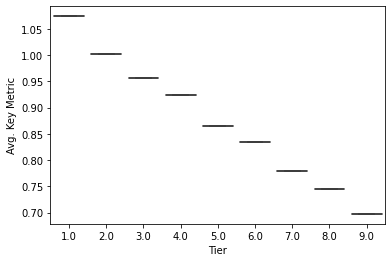

In [ ]:
## Check a visualization of average success metrics of a specific category by tier
category = input()
df = full_df[full_df['Category'] == category]


sns.boxplot(data=df, y='Avg. Key Metric', x='Tier', whis=3);

In [ ]:
significance_df = pd.pivot(data=full_df, index='Category', columns='Tier', values='P-value')
significance_df

Tier,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
Category,,,,,,,,,
Art,0.174726,6.266556e-02,0.040390,8.979525e-02,0.008724,0.079502,0.000785,0.019229,2.182500e-03
Comics,0.439232,1.806310e-02,0.323311,2.266995e-01,0.069793,0.221954,0.116241,0.222892,5.899268e-01
Crafts,0.044433,1.453365e-01,0.017610,3.641003e-02,0.024183,0.284939,0.036634,0.243721,2.499940e-15
Dance,0.021597,8.052466e-01,0.416858,8.949849e-01,0.881641,0.662189,0.975027,0.458722,1.952338e-01
Design,0.045189,1.967719e-03,0.088341,6.276793e-04,0.105156,0.095374,0.062589,0.108242,8.353883e-03
Fashion,0.002157,6.478904e-05,0.001874,2.636986e-01,0.042683,0.861060,0.628369,0.414687,8.017866e-02
Film & Video,0.229823,2.376060e-01,0.371806,4.563940e-01,0.039708,0.114816,0.479999,0.054859,1.093460e-03
Food,0.000900,3.138117e-01,0.023476,6.179068e-01,0.280920,0.581854,0.280015,0.124654,6.673646e-05
Games,0.864946,8.624327e-01,0.725648,1.254185e-01,0.153702,0.041233,0.236534,0.012011,2.948237e-05


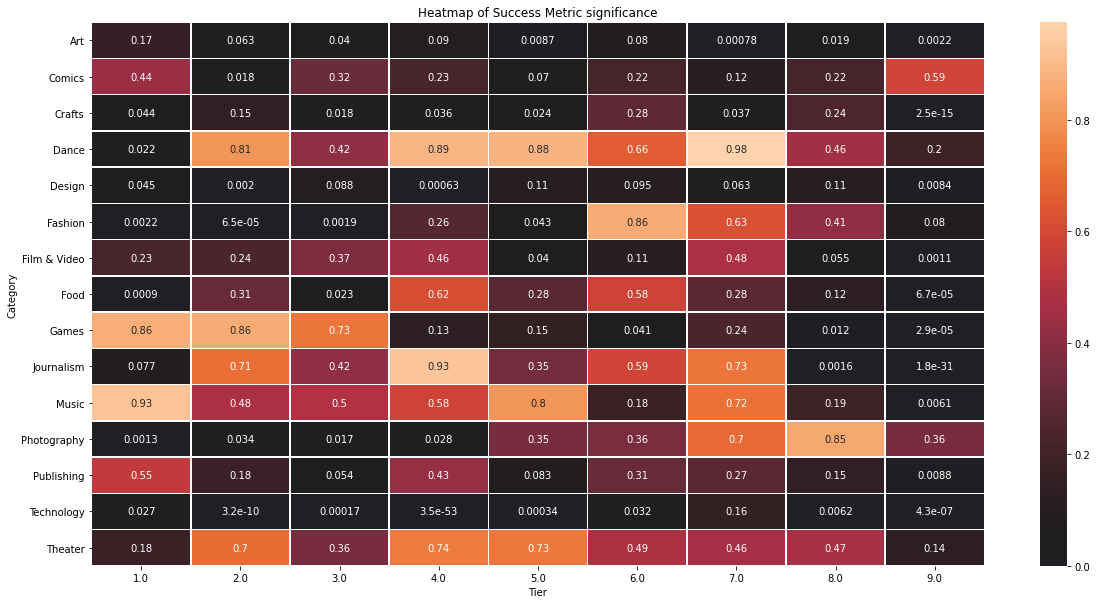

In [ ]:
plt.figure(figsize=(20,10))
plt.title('Heatmap of Success Metric significance')
sns.heatmap(significance_df,  annot=True, linewidths=.5, center=0.05);

## NOTE: Due to retesting, for Technology, Tiers 5 & 6 are NOT significant

In [ ]:
boolean_df = significance_df.copy()
tiers = boolean_df.columns

for column in tiers:
  boolean_df.loc[significance_df[column] >= 0.05, column] = False
  boolean_df.loc[significance_df[column] < 0.05, column] = True

boolean_df

Tier,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
Category,,,,,,,,,
Art,False,False,True,False,True,False,True,True,True
Comics,False,True,False,False,False,False,False,False,False
Crafts,True,False,True,True,True,False,True,False,True
Dance,True,False,False,False,False,False,False,False,False
Design,True,True,False,True,False,False,False,False,True
Fashion,True,True,True,False,True,False,False,False,False
Film & Video,False,False,False,False,True,False,False,False,True
Food,True,False,True,False,False,False,False,False,True
Games,False,False,False,False,False,True,False,True,True


In [ ]:
def sig_test_allcat(df):
  tests = []
  for i in quantiles:
    lower_group = df[df['goal'] > df['goal'].quantile(i - 0.1)]      
    lower_group = df[df['goal'] < df['goal'].quantile(i)]
    iqr_lower = 1.5 * (lower_group['key_metric'].quantile(0.75) - lower_group['key_metric'].quantile(0.25)) #Eliminating outliers
    lower_group = lower_group[lower_group['key_metric'] >= (lower_group['key_metric'].quantile(0.25) - iqr_lower)]
    lower_group = lower_group[lower_group['key_metric'] <= (lower_group['key_metric'].quantile(0.75) + iqr_lower)]


    upper_group = df[df['goal'] > df['goal'].quantile(i)]
    upper_group = df[df['goal'] < df['goal'].quantile(i + 0.1)]
    iqr_upper = 1.5 * (upper_group['key_metric'].quantile(0.75) - upper_group['key_metric'].quantile(0.25)) #Eliminating outliers
    upper_group = upper_group[upper_group['key_metric'] >= (upper_group['key_metric'].quantile(0.25) - iqr_upper)]
    upper_group = upper_group[upper_group['key_metric'] <= (upper_group['key_metric'].quantile(0.75) + iqr_upper)]

  return stats.kruskal(lower_group['key_metric'], upper_group['key_metric'])

In [ ]:
### Let's look at just successful projects
tests_successful = []

for category in categories:
  df = ks_df[ks_df['main_category'] == category]
  df = df[df['key_metric'] >= 1]
  for i in quantiles:
    lower_group = df[df['goal'] > df['goal'].quantile(i - 0.1)]      
    lower_group = df[df['goal'] < df['goal'].quantile(i)]
    iqr_lower = 1.5 * (lower_group['key_metric'].quantile(0.75) - lower_group['key_metric'].quantile(0.25)) #Eliminating outliers
    lower_group = lower_group[lower_group['key_metric'] >= (lower_group['key_metric'].quantile(0.25) - iqr_lower)]
    lower_group = lower_group[lower_group['key_metric'] <= (lower_group['key_metric'].quantile(0.75) + iqr_lower)]


    upper_group = df[df['goal'] > df['goal'].quantile(i)]
    upper_group = df[df['goal'] < df['goal'].quantile(i + 0.1)]
    iqr_upper = 1.5 * (upper_group['key_metric'].quantile(0.75) - upper_group['key_metric'].quantile(0.25)) #Eliminating outliers
    upper_group = upper_group[upper_group['key_metric'] >= (upper_group['key_metric'].quantile(0.25) - iqr_upper)]
    upper_group = upper_group[upper_group['key_metric'] <= (upper_group['key_metric'].quantile(0.75) + iqr_upper)]

    whole_group = df[df['goal'] > df['goal'].quantile(i - 0.1)]
    whole_group = df[df['goal'] < df['goal'].quantile(i + 0.1)]

    j =  stats.f_oneway(lower_group['key_metric'], upper_group['key_metric'])
    tests_successful.append([category, len(whole_group), j[1], str(i*10), whole_group['key_metric'].mean(), 'Skewness: {}  Kurtosis: {}'.format(stats.describe(upper_group['key_metric'])[4],stats.describe(upper_group['key_metric'])[5])])

tests_successful


[['Fashion',
  209,
  0.22158985594042957,
  '1.0',
  1.5737173137517326,
  'Skewness: 1.1463149590492177  Kurtosis: 0.5150802997650303'],
 ['Fashion',
  355,
  0.26200624911391956,
  '2.0',
  1.5575045928718416,
  'Skewness: 1.1841048769376645  Kurtosis: 0.6376984213283525'],
 ['Fashion',
  485,
  0.8060749627354434,
  '3.0',
  1.5443974265981264,
  'Skewness: 1.1890218538296802  Kurtosis: 0.6139560303140854'],
 ['Fashion',
  606,
  0.9415653641473127,
  '4.0',
  1.533188420631666,
  'Skewness: 1.2296613427921228  Kurtosis: 0.652988470646199'],
 ['Fashion',
  728,
  0.4306127259314195,
  '5.0',
  1.5094388838486927,
  'Skewness: 1.2316614858925843  Kurtosis: 0.5964862746322996'],
 ['Fashion',
  849,
  0.14628221359658095,
  '6.0',
  1.4859857134316121,
  'Skewness: 1.242035447319799  Kurtosis: 0.6159602154810226'],
 ['Fashion',
  968,
  0.19429597750069466,
  '7.0',
  1.4689493654782793,
  'Skewness: 1.2408839797254434  Kurtosis: 0.597379517014224'],
 ['Fashion',
  1091,
  0.096292329

In [ ]:
successful_df = pd.DataFrame(tests_successful, columns=['Category', '# of datapoints','P-value','Tier', 'Avg. Key Metric', 'Normality Stats'])
successful_df

,Category,# of datapoints,P-value,Tier,Avg. Key Metric,Normality Stats
0,Fashion,209,0.221590,1.0,1.573717,Skewness: 1.1463149590492177 Kurtosis: 0.5150...
1,Fashion,355,0.262006,2.0,1.557505,Skewness: 1.1841048769376645 Kurtosis: 0.6376...
2,Fashion,485,0.806075,3.0,1.544397,Skewness: 1.1890218538296802 Kurtosis: 0.6139...
3,Fashion,606,0.941565,4.0,1.533188,Skewness: 1.2296613427921228 Kurtosis: 0.6529...
4,Fashion,728,0.430613,5.0,1.509439,Skewness: 1.2316614858925843 Kurtosis: 0.5964...
...,...,...,...,...,...,...
130,Theater,480,0.593592,5.0,1.236659,Skewness: 1.3720084124990364 Kurtosis: 1.1793...
131,Theater,563,0.335095,6.0,1.215076,Skewness: 1.3866921676198722 Kurtosis: 1.2324...
132,Theater,642,0.124870,7.0,1.203885,Skewness: 1.384160318995924 Kurtosis: 1.23044...
133,Theater,720,0.364457,8.0,1.196049,Skewness: 1.3773844161656816 Kurtosis: 1.2115...


In [ ]:
successful_significance_df = pd.pivot(data=successful_df, index='Category', columns='Tier', values='P-value')
successful_significance_df

Tier,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
Category,,,,,,,,,
Art,0.166649,0.606458,0.106102,0.351845,0.056118,0.022218,0.005858,0.006780,0.028245
Comics,0.060850,0.179647,0.123840,0.050530,0.091129,0.000708,0.137944,0.242805,0.452766
Crafts,0.849143,0.995893,0.519835,0.596662,0.774182,0.480572,0.012972,0.318067,0.277097
Dance,0.028532,0.753810,0.075906,0.502250,0.741225,0.421392,0.700955,0.830672,0.776968
Design,0.643322,0.432997,0.340462,0.078299,0.003622,0.690939,0.168523,0.182859,0.723032
Fashion,0.221590,0.262006,0.806075,0.941565,0.430613,0.146282,0.194296,0.096292,0.550617
Film & Video,0.054266,0.001701,0.000657,0.000108,0.196811,0.086806,0.279097,0.256454,0.629649
Food,0.024729,0.001446,0.174059,0.010953,0.475708,0.158942,0.154345,0.697716,0.005999
Games,0.739573,0.697744,0.241602,0.570255,0.705167,0.145046,0.286523,0.822929,0.874752


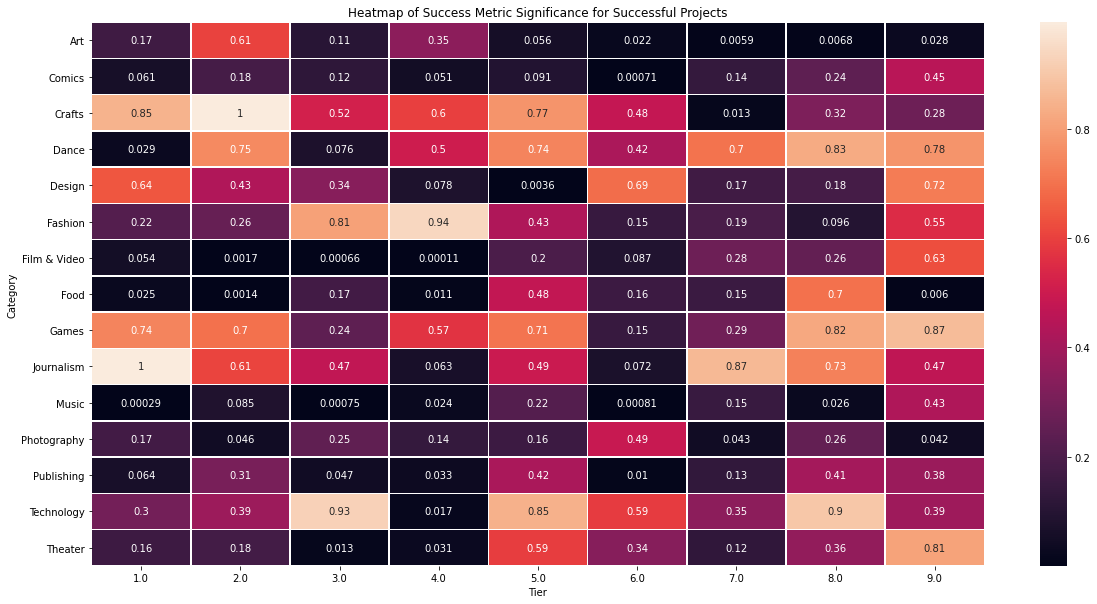

In [ ]:
plt.figure(figsize=(20,10))
plt.title('Heatmap of Success Metric Significance for Successful Projects')
sns.heatmap(successful_significance_df,  annot=True, linewidths=.5);

## NOTE: The gradiant scale is different than the one for all projects; here most projects do NOT have significant results, meaning for MOST projects, there's no significant
## metrics to suggest that increasing goal would be unsuccessful within a tier.  This is tempting for those who think they'll have a successful project, so I would recommend
## to still stick to the data from the overall results